In [14]:
import torch
import transformers
import pandas as pd
import re
import html
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from datasets import load_dataset, Features, Value
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.auto import tqdm
from argparse import Namespace

In [219]:
# Options for 'dataset_name'
# "/data3/mmendieta/Violence_data/case_studies/Russia_Ukraine_combined_with_labels.csv"
# "/data3/mmendieta/Violence_data/case_studies/Israel_Oct7_23_combined_with_labels.csv"
# "/data3/mmendieta/Violence_data/case_studies/Trump_Capitol_Hill_combined_with_labels.csv"

config = {
    "cuda_device": 15,
    "path_to_model_on_disk": "/data3/mmendieta/models/xlmt_finetuned_twitter/", 
    "model_ckpt": "m2im/XLM-T_finetuned_violence_twitter",
    "max_length": 32,
    "dataset_name": "/data3/mmendieta/Violence_data/case_studies/Russia_Ukraine_combined_with_labels.csv",
    "batch_size": 64
}

args = Namespace(**config)

In [220]:
# Define the features with explicit types to prevent automatic casting to integer when reading the csv file
# Cast integer labels to float in order to calculate the predictions 
features = Features({
    'ID': Value('string'),
    'AuthorID': Value('string'),
    'AuthorAlias': Value('string'),
    'CreatedDate': Value('string'),
    'Text': Value('string'),
    'post7geo10': Value('float32'),
    'post7geo30': Value('float32'),
    'post7geo50': Value('float32'),
    'pre7geo10': Value('float32'),
    'pre7geo30': Value('float32'),
    'pre7geo50': Value('float32'),
}) 

In [221]:
# Load the dataset from disk (516ms)
%time ds = load_dataset('csv', data_files= args.dataset_name, sep=",", features=features)

Using custom data configuration default-48d009f57f6cf5e4
Found cached dataset csv (/home/mmendieta/.cache/huggingface/datasets/csv/default-48d009f57f6cf5e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 62.7 ms, sys: 21.5 ms, total: 84.2 ms
Wall time: 290 ms


In [222]:
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'AuthorID', 'AuthorAlias', 'CreatedDate', 'Text', 'post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10', 'pre7geo30', 'pre7geo50'],
        num_rows: 1020
    })
})

In [223]:
# rename the column 'Text' to 'text'
dataset = ds.rename_column('Text', 'text')

In [224]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'AuthorID', 'AuthorAlias', 'CreatedDate', 'text', 'post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10', 'pre7geo30', 'pre7geo50'],
        num_rows: 1020
    })
})

### Preprocess the dataset before inference

In [15]:
# Define a pre-processing function to use with datasets.map()
def clean_tweet(example):
    tweet = example['text']
    tweet = tweet.replace("\n"," ") #cleaning newline “\n” from the tweets
    tweet = html.unescape(tweet) # decode html characters
    tweet = re.sub("@[A-Za-z0-9_:]+","", tweet) # remove mentions
    tweet = re.sub(r'http\S+', '', tweet) # remove urls
    tweet = re.sub('RT ', '', tweet) # remove mentions
    return {'text': tweet.strip()} #strip white spaces

In [225]:
# Filter rows with blank tweets for pre-processing
%time dataset = dataset.filter(lambda x: x["text"] is not None)

Loading cached processed dataset at /home/mmendieta/.cache/huggingface/datasets/csv/default-48d009f57f6cf5e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-4accfb15d35d7e68.arrow


CPU times: user 9.06 ms, sys: 3.67 ms, total: 12.7 ms
Wall time: 10.7 ms


In [226]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'AuthorID', 'AuthorAlias', 'CreatedDate', 'text', 'post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10', 'pre7geo30', 'pre7geo50'],
        num_rows: 1019
    })
})

In [227]:
# Apply the text preprocessing function to the entire dataset
%time dataset_clean = dataset.map(clean_tweet)

Loading cached processed dataset at /home/mmendieta/.cache/huggingface/datasets/csv/default-48d009f57f6cf5e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9baf6247da7ba1d0.arrow


CPU times: user 17.4 ms, sys: 12.6 ms, total: 30 ms
Wall time: 27.3 ms


In [228]:
#  Filter rows with blank text for post-processing
%time dataset_clean = dataset_clean.filter(lambda x: x["text"] is not None)

Loading cached processed dataset at /home/mmendieta/.cache/huggingface/datasets/csv/default-48d009f57f6cf5e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1c132beb3a08c477.arrow


CPU times: user 10.1 ms, sys: 250 µs, total: 10.3 ms
Wall time: 8.18 ms


In [229]:
dataset_clean

DatasetDict({
    train: Dataset({
        features: ['ID', 'AuthorID', 'AuthorAlias', 'CreatedDate', 'text', 'post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10', 'pre7geo30', 'pre7geo50'],
        num_rows: 1019
    })
})

In [230]:
# Remove unncesary columns
keep_cols = ['text', 'pre7geo10', 'pre7geo30', 'pre7geo50', 'post7geo10', 
             'post7geo30', 'post7geo50']
remove_columns = [col for col in dataset_clean['train'].column_names if col not in keep_cols]

In [231]:
dataset_clean = dataset_clean.remove_columns(remove_columns)

In [232]:
dataset_clean["train"].features

{'text': Value(dtype='string', id=None),
 'post7geo10': Value(dtype='float32', id=None),
 'post7geo30': Value(dtype='float32', id=None),
 'post7geo50': Value(dtype='float32', id=None),
 'pre7geo10': Value(dtype='float32', id=None),
 'pre7geo30': Value(dtype='float32', id=None),
 'pre7geo50': Value(dtype='float32', id=None)}

In [233]:
# create 'labels' columm
cols = dataset_clean['train'].column_names
dataset_clean = dataset_clean.map(lambda x : {"labels": [x[c] for c in cols if c != "text"]})
dataset_clean

Loading cached processed dataset at /home/mmendieta/.cache/huggingface/datasets/csv/default-48d009f57f6cf5e4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fa438287fe57148e.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'post7geo10', 'post7geo30', 'post7geo50', 'pre7geo10', 'pre7geo30', 'pre7geo50', 'labels'],
        num_rows: 1019
    })
})

In [234]:
# Keep the dataset only with columns 'text' and 'labels'
col_names = dataset_clean["train"].column_names
col_names.remove("labels")
col_names.remove('text')
ds_clean = dataset_clean.remove_columns(col_names)
ds_clean

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1019
    })
})

# Inference

### Instantiate the required pipeline

In [27]:
violence_pipe = pipeline(model=args.model_ckpt, 
                         device=args.cuda_device,
                         return_all_scores=True)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

### Select specific cases of interest

In [29]:
# Define the label mapping
id2label: {
    "0": "post7geo10",
    "1": "post7geo30",
    "2": "post7geo50",
    "3": "pre7geo10",
    "4": "pre7geo30",
    "5": "pre7geo50"
}

# Define the filtering function to match the required conditions
def filter_condition(example):
    return (example['labels'][0] == 0 and # post7geo10
            example['labels'][1] == 0 and # post7geo30
            example['labels'][2] == 1 and # post7geo50
            example['labels'][3] == 0 and # pre7geo10
            example['labels'][4] == 0 and # pre7geo30
            example['labels'][5] == 0 # pre7geo50
    )

In [30]:
filtered_ds = ds_clean['train'].filter(filter_condition)

Loading cached processed dataset at /home/mmendieta/.cache/huggingface/datasets/csv/default-68d0faf8e5159cd0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fe3a717dcd8c855b.arrow


In [31]:
filtered_ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 6468
})

In [ ]:
filtered_ds[0]['labels']

### Perform inference

In [32]:
# Calculate the predictions
preds = []
for i, outputs in enumerate(tqdm(violence_pipe(KeyDataset(filtered_ds, "text"), batch_size=args.batch_size,
                                              truncation=True),
                                 total=len(filtered_ds))):
    text = filtered_ds[i]['text']
    labels = filtered_ds[i]['labels']
    preds.append({
        'text': text,
        'labels': labels,
        'outputs': outputs
    })

  0%|          | 0/6468 [00:00<?, ?it/s]

In [33]:
# Iterate over the predictions to visualize the text, true labels, and predictions
processed_data = []
for pred in preds:
    row = {
        'text': pred['text'],
        'true_labels': pred['labels'],
    }
    # Add each of the six pedicted scores as separate columns
    row['post7geo10'] = pred['outputs'][0]['score']
    row['post7geo30'] = pred['outputs'][1]['score']
    row['post7geo50'] = pred['outputs'][2]['score']
    row['pre7geo10'] = pred['outputs'][3]['score']
    row['pre7geo30'] = pred['outputs'][4]['score']
    row['pre7geo50'] = pred['outputs'][5]['score']
    
    processed_data.append(row)
    
# Convert to DataFrame
df = pd.DataFrame(processed_data)

In [34]:
df.head(3)

,text,true_labels,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
0,What would you do 🥱,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0.275789,0.375137,0.489425,0.274000,0.360397,0.466075
1,They were LET IN! just like we said #CapitolB...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0.763389,0.810380,0.863128,0.294917,0.328344,0.369649
2,You are correct Sir! 👀🇺🇸‼️,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0.295641,0.355861,0.465822,0.275853,0.341913,0.439394


In [35]:
mean_preds = df.mean().to_frame(name='mean').T
mean_preds 

/tmp/ipykernel_32963/3262774732.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_preds = df.mean().to_frame(name='mean').T


,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
mean,0.310626,0.397994,0.546078,0.303492,0.384985,0.52347


In [36]:
mean_preds_th = (mean_preds >= 0.5).astype(int)
mean_preds_th

,post7geo10,post7geo30,post7geo50,pre7geo10,pre7geo30,pre7geo50
mean,0,0,1,0,0,1


### ROC and AUC score (Trump and Russia only - six labels)

In [235]:
# Calculate the predictions on the entire case study dataset (only Trump and Russia)
preds = []
for i, outputs in enumerate(tqdm(violence_pipe(KeyDataset(ds_clean['train'], "text"), batch_size=args.batch_size,
                                              truncation=True),
                                 total=len(ds_clean['train']))):
    text = ds_clean['train'][i]['text']
    labels = ds_clean['train'][i]['labels']
    preds.append({
        'text': text,
        'labels': labels,
        'outputs': outputs
    })

/home/mmendieta/transformers/lib/python3.8/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/1019 [00:00<?, ?it/s]

In [236]:
# Step 1: Calculate the ROC-AUC score
# Extract the ground truth labels and predicted probabilities for each label
true_labels = np.array([item['labels'] for item in preds])

# Convert prediction scores to a 2D array of floats
prediction_scores = np.array([
    [score['score'] for score in item['outputs']] for item in preds
])

In [ ]:
prediction_scores

In [237]:
# Initialize the Evaluate API for ROC-AUC
roc_auc = evaluate.load("roc_auc")

In [238]:
# Calculate ROC-AUC scores for each label

# Labels of interest
labels = ["post7geo10", "post7geo30", "post7geo50", "pre7geo10", "pre7geo30", "pre7geo50"]

roc_auc_scores = {}

for i, label_name in enumerate(labels):
    roc_auc_result = roc_auc.compute(
        prediction_scores=prediction_scores[:, i], 
        references=true_labels[:, i]
    )
    roc_auc_scores[label_name] = roc_auc_result['roc_auc']

In [239]:
# Calculate the average ROC_AUC across the six labels
average_roc_auc = sum(roc_auc_scores.values()) / len(roc_auc_scores)
print(f"Average ROC-AUC Score: {average_roc_auc:.2}")

Average ROC-AUC Score: 0.46


In [240]:
# Display individual ROC-AUC scores
for label, score in roc_auc_scores.items():
    print(f"ROC-AUC score for {label}: {score}")

ROC-AUC score for post7geo10: 0.4684729064039409
ROC-AUC score for post7geo30: 0.3556998556998557
ROC-AUC score for post7geo50: 0.5677491999525898
ROC-AUC score for pre7geo10: 0.4476284584980237
ROC-AUC score for pre7geo30: 0.42333812197988774
ROC-AUC score for pre7geo50: 0.524744182371301


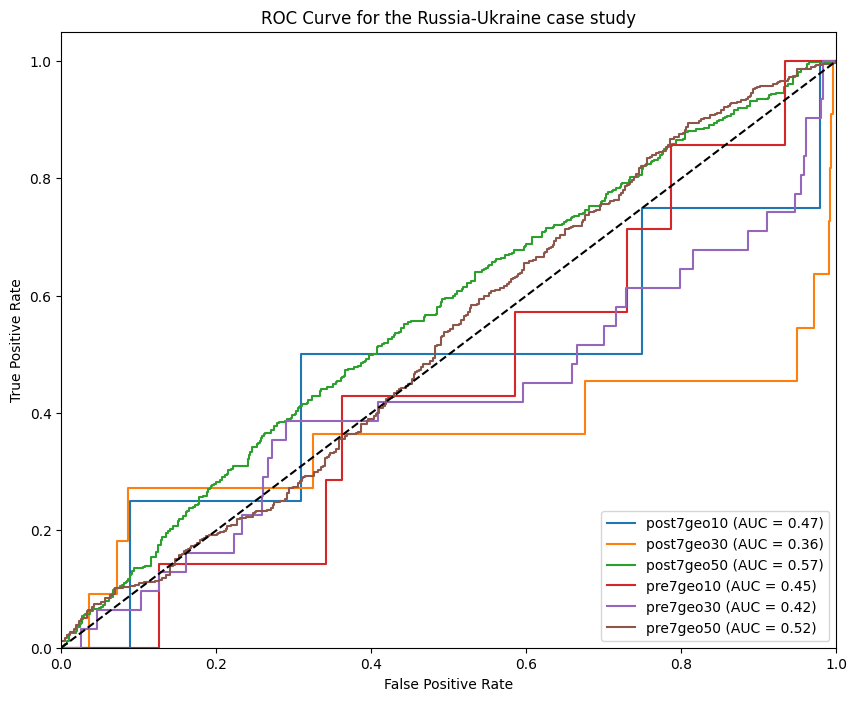

In [241]:
# Step 2: Plot the ROC curve for each label
plt.figure(figsize=(10, 8))

for i, label_name in enumerate(["post7geo10", "post7geo30", "post7geo50", "pre7geo10", "pre7geo30", "pre7geo50"]):
    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(true_labels[:, i], prediction_scores[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{label_name} (AUC = {roc_auc_scores[label_name]:.2f})")

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Russia-Ukraine case study')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

In [101]:
# Save to disk
plt.savefig("/data3/mmendieta/Violence_data/case_studies/figs/ROC_Russia_Ukraine.eps", 
            format="eps", dpi=300,  bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

# ROC-AUC scores for the Israel case study

In [170]:
# Calculate the predictions on the entire dataset
preds = []
for i, outputs in enumerate(tqdm(violence_pipe(KeyDataset(ds_clean['train'], "text"), batch_size=args.batch_size,
                                              truncation=True),
                                 total=len(ds_clean['train']))):
    text = ds_clean['train'][i]['text']
    labels = ds_clean['train'][i]['labels']
    preds.append({
        'text': text,
        'labels': labels,
        'outputs': outputs
    })

  0%|          | 0/9615 [00:00<?, ?it/s]

In [172]:
# Initialize the Evaluate API for ROC-AUC
roc_auc = evaluate.load("roc_auc")

In [182]:
# Labels of interest
labels = ["post7geo50", "pre7geo50"]

In [188]:
# Step 1: Calculate the ROC-AUC score
# Filter true labels and prediction scores for the two labels of interest
# The `id2label` map is: {2: "post7geo50", 5: "pre7geo50"}
label_indices = [2, 5]
true_labels = np.array([[item['labels'][idx] for idx in label_indices] for item in preds])

# Convert prediction scores to a 2D array of floats
prediction_scores = np.array([[item['outputs'][idx]['score'] for idx in label_indices] for item in preds])

In [189]:
# Calculate ROC-AUC scores for each label
roc_auc_scores = {}

for i, label_name in enumerate(labels):
    roc_auc_result = roc_auc.compute(
        prediction_scores=prediction_scores[:, i], 
        references=true_labels[:, i]
    )
    roc_auc_scores[label_name] = roc_auc_result['roc_auc']

In [190]:
# Calculate the average ROC-AUC across the two labels
average_roc_auc = sum(roc_auc_scores.values()) / len(roc_auc_scores)
print(f"Average ROC-AUC Score: {average_roc_auc:.2f}")

Average ROC-AUC Score: 0.51


In [191]:
# Display individual ROC-AUC scores
for label, score in roc_auc_scores.items():
    print(f"ROC-AUC score for {label}: {score}")

ROC-AUC score for post7geo50: 0.6189454412566184
ROC-AUC score for pre7geo50: 0.4054554070418779


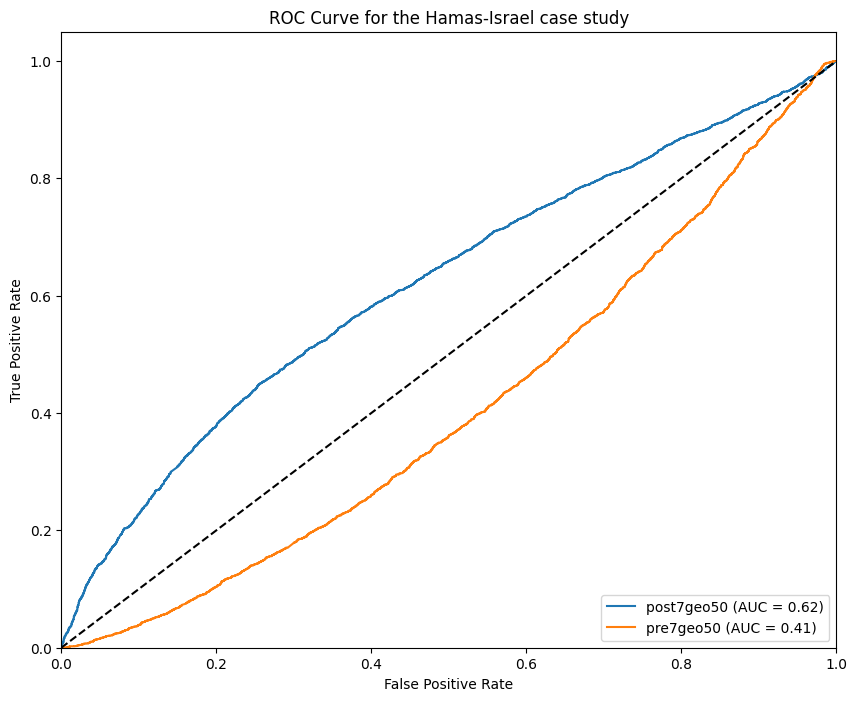

In [193]:
# Step 2: Plot the ROC curve for each label
plt.figure(figsize=(10, 8))

for i, label_name in enumerate(labels):
    # Calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(true_labels[:, i], prediction_scores[:, i])
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{label_name} (AUC = {roc_auc_scores[label_name]:.2f})")

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Hamas-Israel case study')
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

In [194]:
# Save to disk
plt.savefig("/data3/mmendieta/Violence_data/case_studies/figs/ROC_Hamas_Israel.eps", 
            format="eps", dpi=300,  bbox_inches="tight")

<Figure size 640x480 with 0 Axes>